# Fraud Detection - Data Preprocessing & Model Training
## Azure Cloud Data-Driven Application Project

**Project:** Detection of fraud in financial transactions  
**Dataset:** 6M rows → Truncated & Balanced for optimal training  
**Goal:** Train a high-performance fraud detection model

---

## Pipeline Overview:
1. **Data Loading & Exploration**
2. **Strategic Truncation** (All frauds + 500k non-frauds)
3. **Data Balancing with SMOTE** (40/60 or customizable ratio)
4. **Feature Engineering & Preprocessing**
5. **Model Training** (Multiple algorithms)
6. **Model Evaluation & Comparison**
7. **Export Best Model** for deployment

## 📦 1. Import Required Libraries

In [1]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xgboost lightgbm
%pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [29]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import resample

# Balancing techniques
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Model persistence
import joblib
import pickle

# For experiment tracking (if using MLflow)
try:
    import mlflow
    import mlflow.sklearn
    MLFLOW_AVAILABLE = True
    print("✅ MLflow is available for experiment tracking")
except ImportError:
    MLFLOW_AVAILABLE = False
    print("⚠️ MLflow not available. Install with: pip install mlflow")

print("\n✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ MLflow is available for experiment tracking

✅ All libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 2.2.6


## 📊 2. Load and Explore Dataset

In [5]:
!pip install azureml-dataset-runtime --upgrade

In [30]:
# Configuration
from datetime import datetime
import pandas as pd
from azureml.core import Workspace, Dataset

DATA_PATH = 'fraud_dataset.csv'  
TARGET_COLUMN = 'isFraud'

print("📂 Loading dataset...")
print(f"File: {DATA_PATH}")
print(f"Loading started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# Connect to Azure ML Workspace
ws = Workspace.from_config()
datastore = ws.get_default_datastore()

# Load dataset FROM BLOB STORAGE
dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, DATA_PATH)]
)

df = dataset.to_pandas_dataframe()

print(f"✅ Dataset loaded successfully!")
print(f"Loading completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# Display basic information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total rows: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]:,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
display(df.head())


📂 Loading dataset...
File: fraud_dataset.csv
Loading started at: 2025-12-17 09:53:10

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
✅ Dataset loaded successfully!
Loading completed at: 2025-12-17 09:53:19

DATASET OVERVIEW
Total rows: 6,362,620
Total columns: 11
Memory usage: 1610.36 MB

First few rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,True,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,False,False
1,True,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,False,False
2,True,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,True,False
3,True,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,True,False
4,True,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,False,False


In [31]:
# Examine data types and missing values
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)

print("\n📋 Column Information:")
df.info()

print("\n❓ Missing Values:")
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

print("\n📊 Basic Statistics:")
display(df.describe())


DATA QUALITY CHECK

📋 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            object 
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         bool   
 10  isFlaggedFraud  bool   
dtypes: bool(2), float64(5), object(4)
memory usage: 449.0+ MB

❓ Missing Values:
      Missing Count  Percentage
step        6359912   99.957439

📊 Basic Statistics:


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


## 🎯 3. Analyze Class Distribution (Before Truncation)

CLASS DISTRIBUTION ANALYSIS

📊 Original Dataset Distribution:

Non-Fraud (0): 6,354,407 (99.87%)
Fraud (1):     8,213 (0.13%)

Imbalance Ratio: 1:773.7
Total samples: 6,362,620


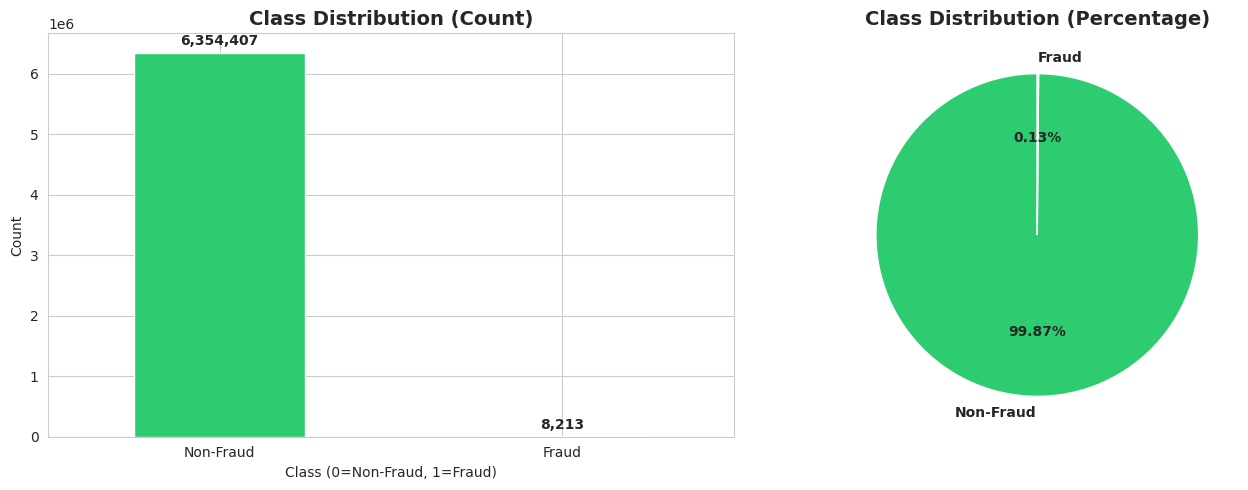


⚠️ This dataset is highly imbalanced - balancing is necessary!


In [32]:
import matplotlib.pyplot as plt
print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

# Count fraud vs non-fraud cases
fraud_counts = df[TARGET_COLUMN].value_counts()
fraud_pct = df[TARGET_COLUMN].value_counts(normalize=True) * 100

print("\n📊 Original Dataset Distribution:")
print(f"\nNon-Fraud (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraud (1):     {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{fraud_counts[0]/fraud_counts[1]:.1f}")
print(f"Total samples: {len(df):,}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
fraud_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(fraud_counts):
    axes[0].text(i, v + max(fraud_counts)*0.02, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90, textprops={'fontweight': 'bold'})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ This dataset is highly imbalanced - balancing is necessary!")

## ✂️ 4. Strategic Dataset Truncation

**Strategy:**
- Keep ALL fraud cases (minority class)
- Sample 500,000 non-fraud cases (majority class)
- This reduces computational load while preserving all fraud patterns

In [33]:
print("="*60)
print("DATASET TRUNCATION")
print("="*60)

# Separate fraud and non-fraud cases
fraud_cases = df[df[TARGET_COLUMN] == 1]
non_fraud_cases = df[df[TARGET_COLUMN] == 0]

print(f"\n📊 Original Split:")
print(f"Fraud cases:     {len(fraud_cases):,}")
print(f"Non-fraud cases: {len(non_fraud_cases):,}")

# Keep all frauds, sample non-frauds
NON_FRAUD_SAMPLE_SIZE = 500_000

print(f"\n✂️ Truncation Strategy:")
print(f"✓ Keep ALL {len(fraud_cases):,} fraud cases")
print(f"✓ Sample {NON_FRAUD_SAMPLE_SIZE:,} non-fraud cases")

# Random sampling of non-fraud cases
non_fraud_sampled = non_fraud_cases.sample(
    n=min(NON_FRAUD_SAMPLE_SIZE, len(non_fraud_cases)),
    random_state=42
)

# Combine truncated datasets
df_truncated = pd.concat([fraud_cases, non_fraud_sampled], axis=0)
df_truncated = df_truncated.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"\n✅ Truncation Complete!")
print(f"\n📊 Truncated Dataset:")
print(f"Total rows: {len(df_truncated):,}")
print(f"Fraud:      {len(df_truncated[df_truncated[TARGET_COLUMN] == 1]):,}")
print(f"Non-fraud:  {len(df_truncated[df_truncated[TARGET_COLUMN] == 0]):,}")

truncated_ratio = len(df_truncated[df_truncated[TARGET_COLUMN] == 0]) / len(df_truncated[df_truncated[TARGET_COLUMN] == 1])
print(f"\nNew Imbalance Ratio: 1:{truncated_ratio:.1f}")
print(f"Size reduction: {100 * (1 - len(df_truncated)/len(df)):.1f}%")

# Memory cleanup
del df, fraud_cases, non_fraud_cases, non_fraud_sampled
import gc
gc.collect()

print("\n🧹 Memory cleaned up")

DATASET TRUNCATION

📊 Original Split:
Fraud cases:     8,213
Non-fraud cases: 6,354,407

✂️ Truncation Strategy:
✓ Keep ALL 8,213 fraud cases
✓ Sample 500,000 non-fraud cases

✅ Truncation Complete!

📊 Truncated Dataset:
Total rows: 508,213
Fraud:      8,213
Non-fraud:  500,000

New Imbalance Ratio: 1:60.9
Size reduction: 92.0%

🧹 Memory cleaned up


## 🔧 5. Feature Engineering & Preprocessing

In [9]:
import sys
!{sys.executable} -m pip install category_encoders

In [34]:
import pandas as pd
import numpy as np

# Assuming df_truncated is already loaded
TARGET_COLUMN = 'isFraud'  # Replace with your actual target column name

# 1️⃣ Identify categorical columns
categorical_cols = df_truncated.select_dtypes(include=['object', 'category']).columns
numeric_cols = df_truncated.select_dtypes(include=[np.number]).columns

# 2️⃣ Handle missing values
print("="*60)
print("FEATURE ENGINEERING - Missing Values")
print("="*60)

for col in numeric_cols:
    if df_truncated[col].isnull().sum() > 0:
        df_truncated[col].fillna(df_truncated[col].median(), inplace=True)
        print(f"Filled missing values in {col} with median")

for col in categorical_cols:
    if df_truncated[col].isnull().sum() > 0:
        df_truncated[col].fillna(df_truncated[col].mode()[0], inplace=True)
        print(f"Filled missing values in {col} with mode")

# 3️⃣ Encode categorical columns using Target Encoding
!pip install -q category_encoders
import category_encoders as ce

if len(categorical_cols) > 0:
    print(f"\n🔤 Encoding {len(categorical_cols)} categorical columns using Target Encoding...")
    encoder = ce.TargetEncoder(cols=categorical_cols)
    df_truncated[categorical_cols] = encoder.fit_transform(df_truncated[categorical_cols], df_truncated[TARGET_COLUMN])
    print("✓ Encoding complete")
else:
    print("No categorical columns to encode")

# 4️⃣ Optional: Scale numeric columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_truncated[numeric_cols] = scaler.fit_transform(df_truncated[numeric_cols])
df_processed = df_truncated.copy()

print("\n✓ Feature scaling complete")


FEATURE ENGINEERING - Missing Values
Filled missing values in step with mode

🔤 Encoding 4 categorical columns using Target Encoding...
✓ Encoding complete

✓ Feature scaling complete


## 🎯 6. Data Balancing with SMOTE

**Multiple balancing strategies available:**
- **SMOTE**: Synthetic Minority Over-sampling Technique
- **ADASYN**: Adaptive Synthetic Sampling
- **BorderlineSMOTE**: Focus on borderline cases
- **SMOTETomek**: SMOTE + Tomek Links cleaning

We'll use **SMOTE** with customizable ratio (40:60, 45:55, or 50:50)

In [11]:
import imblearn
from imblearn.over_sampling import SMOTE
print(imblearn.__file__)
print(SMOTE)


/anaconda/envs/jupyter_env/lib/python3.10/site-packages/imblearn/__init__.py
<class 'imblearn.over_sampling._smote.base.SMOTE'>


In [132]:
from sklearn.model_selection import train_test_split

# Split original dataset BEFORE balancing
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [133]:
from imblearn.over_sampling import SMOTE
print("="*60)
print("DATA BALANCING WITH SMOTE")
print("="*60)

# Separate features and target
X = df_processed.drop(columns=[TARGET_COLUMN])
y = df_processed[TARGET_COLUMN]

print(f"\n📊 Before Balancing:")
print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Fraud ratio: {100 * y.mean():.2f}%")

# Choose your desired balance ratio
# Options: 0.4 (40%), 0.45 (45%), 0.5 (50%)
DESIRED_FRAUD_RATIO = 0.40  # ⚠️ ADJUST THIS (0.40 = 40/60 split)

# Calculate sampling strategy
# sampling_strategy: ratio of minority class to majority class after resampling
# For 40% fraud: we want fraud/(non-fraud) = 0.4/0.6 = 0.667
sampling_strategy = DESIRED_FRAUD_RATIO / (1 - DESIRED_FRAUD_RATIO)

print(f"\n🎯 Target Balance:")
print(f"Desired fraud ratio: {DESIRED_FRAUD_RATIO*100:.0f}%")
print(f"Sampling strategy: {sampling_strategy:.3f}")

# Apply SMOTE
print(f"\n⚙️ Applying SMOTE...")
smote = SMOTE(
    sampling_strategy=sampling_strategy,
    random_state=42,
    k_neighbors=5)

X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"\n✅ SMOTE Complete!")
print(f"\n📊 After Balancing:")
print(f"Features shape: {X_balanced.shape}")
print(f"Target distribution:")
print(pd.Series(y_balanced).value_counts())
fraud_pct_balanced = 100 * pd.Series(y_balanced).mean()
print(f"\nFraud ratio: {fraud_pct_balanced:.2f}%")
print(f"Total samples: {len(X_balanced):,}")
print(f"Synthetic samples created: {len(X_balanced) - len(X):,}")

DATA BALANCING WITH SMOTE

📊 Before Balancing:
Features shape: (508213, 10)
Target distribution:
isFraud
False    500000
True       8213
Name: count, dtype: int64
Fraud ratio: 1.62%

🎯 Target Balance:
Desired fraud ratio: 40%
Sampling strategy: 0.667

⚙️ Applying SMOTE...

✅ SMOTE Complete!

📊 After Balancing:
Features shape: (833333, 10)
Target distribution:
isFraud
False    500000
True     333333
Name: count, dtype: int64

Fraud ratio: 40.00%
Total samples: 833,333
Synthetic samples created: 325,120


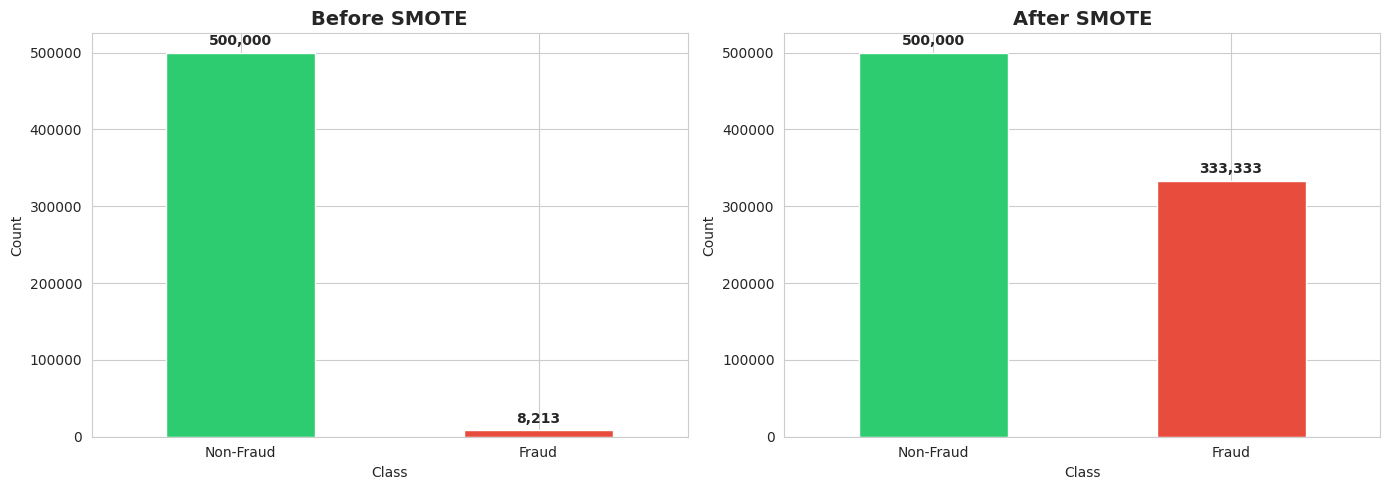


📈 Dataset is now balanced and ready for training!


In [134]:
# Visualize the balancing effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y.value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(y.value_counts()):
    axes[0].text(i, v + max(y.value_counts())*0.02, f'{v:,}', ha='center', fontweight='bold')

# After SMOTE
pd.Series(y_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(pd.Series(y_balanced).value_counts()):
    axes[1].text(i, v + max(pd.Series(y_balanced).value_counts())*0.02, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📈 Dataset is now balanced and ready for training!")

In [135]:
X_balanced = X_balanced.drop(columns=leakage_cols)


## 🔀 7. Train-Test Split & Scaling

In [136]:
leakage_cols = ['nameOrig', 'nameDest', 'isFlaggedFraud']
X = X.drop(columns=leakage_cols)


In [137]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train_orig, y_train_orig)


In [138]:
print("="*60)
print("TRAIN-TEST SPLIT & FEATURE SCALING")
print("="*60)

# Split the balanced dataset
TEST_SIZE = 0.2  # 80% train, 20% test
RANDOM_STATE = 42

# 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2
    random_state=42,
    stratify=y_temp
)

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)
print(f"\n✅ Data split complete:")
print(f"\nTraining set:   {X_train.shape[0]:,} samples ({100*(1-TEST_SIZE):.0f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({100*TEST_SIZE:.0f}%)")
print(f"Number of features: {X_train.shape[1]}")

print(f"\n📊 Class distribution:")
print(f"Train - Fraud: {pd.Series(y_train).mean()*100:.2f}%")
print(f"Test  - Fraud: {pd.Series(y_test).mean()*100:.2f}%")

# Feature Scaling (Important for many algorithms)
print(f"\n⚙️ Applying feature scaling...")

# RobustScaler is better for data with outliers (common in fraud detection)

print("Features utilisées :", X_train.columns.tolist())

# Récupération des noms de features pour l'analyse après scaling
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = [f'feature_{i}' for i in range(X_train_scaled.shape[1])]

# Créer DataFrame pour statistiques
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)

# Alternative: StandardScaler() for normal distribution


print("✅ Scaling complete using RobustScaler")
print("\n📦 Data is now ready for model training!")


TRAIN-TEST SPLIT & FEATURE SCALING

✅ Data split complete:

Training set:   499,999 samples (80%)
Test set:       166,667 samples (20%)
Number of features: 7

📊 Class distribution:
Train - Fraud: 40.00%
Test  - Fraud: 40.00%

⚙️ Applying feature scaling...
Features utilisées : ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
✅ Scaling complete using RobustScaler

📦 Data is now ready for model training!


## 🤖 8. Model Training & Evaluation

We'll train multiple models and compare their performance:
1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting
4. XGBoost
5. LightGBM

In [139]:
# =============================================================================
# PARTIE 1: CONFIGURATION AZURE ML + MLFLOW
# =============================================================================

print("="*80)
print(" "*20 + "🚀 AZURE ML - MODEL TRAINING PIPELINE")
print("="*80)

import warnings
warnings.filterwarnings('ignore')

# Imports essentiels
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os

# Azure ML
from azureml.core import Workspace, Experiment, Run, Dataset, Model
from azureml.core.compute import ComputeTarget
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métriques
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

print("\n✅ Toutes les bibliothèques importées avec succès!")

                    🚀 AZURE ML - MODEL TRAINING PIPELINE

✅ Toutes les bibliothèques importées avec succès!


In [140]:
# =============================================================================
# CONNEXION AU WORKSPACE AZURE ML
# =============================================================================

print("\n" + "="*80)
print("📡 CONNEXION À AZURE ML WORKSPACE")
print("="*80)

try:
    # Méthode 1: Depuis le contexte du run (si dans Azure ML Compute)
    run_context = Run.get_context()
    
    if hasattr(run_context, 'experiment'):
        ws = run_context.experiment.workspace
        print("✅ Connecté depuis Azure ML Compute Instance")
    else:
        # Méthode 2: Depuis config.json local
        ws = Workspace.from_config()
        print("✅ Connecté depuis configuration locale")
    
    print(f"\n📋 Workspace Details:")
    print(f"   Nom: {ws.name}")
    print(f"   Région: {ws.location}")
    print(f"   Resource Group: {ws.resource_group}")
    print(f"   Subscription ID: {ws.subscription_id[:8]}...")
    
    # Configuration MLflow pour Azure ML
    mlflow_uri = ws.get_mlflow_tracking_uri()
    mlflow.set_tracking_uri(mlflow_uri)
    print(f"\n🔗 MLflow Tracking URI configuré: {mlflow_uri}")
    
    AZURE_ML_CONNECTED = True

except Exception as e:
    print(f"⚠️ Erreur de connexion: {str(e)}")
    print("💡 Utilisation du mode local pour démonstration")
    AZURE_ML_CONNECTED = False
    mlflow.set_tracking_uri("./mlruns")

# Créer/Récupérer l'expérience
EXPERIMENT_NAME = "fraud-detection-training"
experiment = Experiment(workspace=ws, name=EXPERIMENT_NAME) if AZURE_ML_CONNECTED else None

if AZURE_ML_CONNECTED:
    print(f"\n🧪 Expérience: {EXPERIMENT_NAME}")
    mlflow.set_experiment(EXPERIMENT_NAME)
else:
    mlflow.set_experiment("fraud-detection-local")

print("\n" + "="*80)


📡 CONNEXION À AZURE ML WORKSPACE
✅ Connecté depuis configuration locale

📋 Workspace Details:
   Nom: creditfraudml
   Région: spaincentral
   Resource Group: credit-fraud
   Subscription ID: 324b7eb1...

🔗 MLflow Tracking URI configuré: azureml://spaincentral.api.azureml.ms/mlflow/v2.0/subscriptions/324b7eb1-4bf6-45c1-a505-8240d4d66a67/resourceGroups/credit-fraud/providers/Microsoft.MachineLearningServices/workspaces/creditfraudml?

🧪 Expérience: fraud-detection-training



In [141]:
# =============================================================================
# PARTIE 2: CHARGEMENT DES DONNÉES (depuis Azure Blob Storage)
# =============================================================================

print("\n" + "="*80)
print("📂 CHARGEMENT DES DONNÉES DEPUIS AZURE BLOB STORAGE")
print("="*80)

# Supposons que X_train_scaled, X_test_scaled, y_train, y_test sont déjà préparés
# Si ce n'est pas le cas, décommentez le code ci-dessous:

"""
# Charger depuis Azure Blob Storage
datastore = ws.get_default_datastore()
dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, 'fraud_dataset_processed.csv')]
)
df = dataset.to_pandas_dataframe()

# Séparer features et target
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

print(f"✅ Données chargées:")
print(f"   Training samples: {len(X_train_scaled):,}")
print(f"   Test samples: {len(X_test_scaled):,}")
print(f"   Features: {X_train_scaled.shape[1]}")
print(f"   Fraud ratio (train): {pd.Series(y_train).mean()*100:.2f}%")




📂 CHARGEMENT DES DONNÉES DEPUIS AZURE BLOB STORAGE
✅ Données chargées:
   Training samples: 499,999
   Test samples: 166,667
   Features: 7
   Fraud ratio (train): 40.00%


In [142]:
# =============================================================================
# PARTIE 3: FONCTION D'ÉVALUATION COMPLÈTE
# =============================================================================

def evaluate_model_comprehensive(model, X_test, y_test, model_name="Model"):
    """
    Évaluation complète du modèle avec visualisations professionnelles
    
    Returns:
        dict: Métriques de performance
        tuple: Figures matplotlib pour logging
    """
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Métriques supplémentaires pour fraude
    tn, fp, fn, tp = cm.ravel()
    metrics['true_negatives'] = int(tn)
    metrics['false_positives'] = int(fp)
    metrics['false_negatives'] = int(fn)
    metrics['true_positives'] = int(tp)
    metrics['fraud_detection_rate'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['false_alarm_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Affichage des résultats
    print(f"\n{'='*70}")
    print(f"📊 {model_name} - RÉSULTATS D'ÉVALUATION")
    print(f"{'='*70}")
    print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"Precision: {metrics['precision']:.4f} (Qualité des alertes fraude)")
    print(f"Recall:    {metrics['recall']:.4f} (Détection des fraudes)")
    print(f"F1-Score:  {metrics['f1_score']:.4f} (Balance Precision/Recall)")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f} (Capacité de discrimination)")
    
    print(f"\n🎯 Métriques métier spécifiques:")
    print(f"Taux de détection fraude: {metrics['fraud_detection_rate']*100:.2f}%")
    print(f"Taux de fausses alertes:  {metrics['false_alarm_rate']*100:.2f}%")
    
    print(f"\n🔢 Confusion Matrix:")
    print(f"   TN: {tn:,}  |  FP: {fp:,}")
    print(f"   FN: {fn:,}  |  TP: {tp:,}")
    
    # Visualisations
    fig = plt.figure(figsize=(18, 5))
    
    # 1. Confusion Matrix
    ax1 = plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Fraude', 'Fraude'],
                yticklabels=['Non-Fraude', 'Fraude'],
                ax=ax1, cbar_kws={'label': 'Nombre de cas'})
    ax1.set_title(f'{model_name}\nMatrice de Confusion', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Vraie Classe')
    ax1.set_xlabel('Classe Prédite')
    
    # 2. ROC Curve
    ax2 = plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, linewidth=2.5, 
             label=f'ROC (AUC = {metrics["roc_auc"]:.3f})', color='#e74c3c')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Hasard')
    ax2.set_xlabel('Taux de Faux Positifs (FPR)')
    ax2.set_ylabel('Taux de Vrais Positifs (TPR)')
    ax2.set_title(f'{model_name}\nCourbe ROC', fontweight='bold', fontsize=12)
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.3)
    
    # 3. Precision-Recall Curve
    ax3 = plt.subplot(1, 3, 3)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    ax3.plot(recall_vals, precision_vals, linewidth=2.5, color='#2ecc71')
    ax3.set_xlabel('Recall (Taux de détection)')
    ax3.set_ylabel('Precision (Qualité des alertes)')
    ax3.set_title(f'{model_name}\nCourbe Precision-Recall', fontweight='bold', fontsize=12)
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show() 
    return metrics, fig

print("\n✅ Fonction d'évaluation configurée")



✅ Fonction d'évaluation configurée


In [104]:
leakage_cols = ['nameOrig', 'nameDest', 'isFlaggedFraud']
X = X.drop(columns=leakage_cols)


In [143]:
# =============================================================================
# PARTIE 4: CONFIGURATION DES MODÈLES (VERSION CORRIGÉE)
# =============================================================================

print("\n" + "="*80)
print("🤖 CONFIGURATION DES MODÈLES DE MACHINE LEARNING")
print("="*80)

# IMPORTANT: Vérifier d'abord le déséquilibre réel de vos données
print(f"\n📊 Analyse du déséquilibre des classes:")
fraud_count = y_train.sum()
total_count = len(y_train)
fraud_ratio = fraud_count / total_count
print(f"   • Transactions frauduleuses: {fraud_count:,} ({fraud_ratio*100:.2f}%)")
print(f"   • Transactions légitimes: {total_count - fraud_count:,} ({(1-fraud_ratio)*100:.2f}%)")
print(f"   • Ratio déséquilibre: 1:{int(1/fraud_ratio)}")

# Calculer le scale_pos_weight optimal pour XGBoost
# scale_pos_weight = (nombre de négatifs) / (nombre de positifs)
scale_pos_weight = (total_count - fraud_count) / fraud_count
print(f"   • scale_pos_weight optimal: {scale_pos_weight:.2f}")

# Configuration des modèles avec hyperparamètres CORRIGÉS
models_config = {
    'Logistic_Regression': {
        'model': LogisticRegression(
            max_iter=1000,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced',  # OK pour la régression logistique
            solver='saga',
            penalty='l2',
            C=1.0  # Régularisation standard
        ),
        'description': 'Modèle linéaire baseline - Rapide et interprétable',
        'color': '#3498db'
    },
    
    'Random_Forest': {
        'model': RandomForestClassifier(
            n_estimators=100,  # Réduit de 150 à 100
            max_depth=15,      # Réduit de 20 à 15 (évite l'overfitting)
            min_samples_split=10,  # Augmenté de 5 à 10
            min_samples_leaf=4,    # Augmenté de 2 à 4
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            class_weight='balanced_subsample',  # Mieux que 'balanced'
            verbose=0,
            max_samples=0.8  # Sous-échantillonnage pour éviter overfitting
        ),
        'description': 'Ensemble d\'arbres - Robuste et performant',
        'color': '#2ecc71'
    },
    
    'XGBoost': {
        'model': XGBClassifier(
            n_estimators=100,  # Réduit de 150
            max_depth=6,       # Réduit de 10 à 6 (XGBoost recommande 3-10)
            learning_rate=0.05, # Réduit de 0.1 à 0.05 (apprentissage plus lent)
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            min_child_weight=3,  # Ajouté pour éviter overfitting
            scale_pos_weight=min(scale_pos_weight, 10),  # Limité à max 10
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss',
            verbosity=0,
            reg_alpha=0.1,  # Régularisation L1
            reg_lambda=1.0  # Régularisation L2
        ),
        'description': 'Gradient Boosting optimisé - Très haute performance',
        'color': '#e74c3c'
    },
    
    'LightGBM': {
        'model': LGBMClassifier(
            n_estimators=100,
            max_depth=6,      # Réduit de 10
            learning_rate=0.05, # Réduit de 0.1
            subsample=0.8,
            colsample_bytree=0.8,
            num_leaves=31,
            min_child_samples=30,  # Augmenté de 20 à 30
            min_child_weight=0.001,
            random_state=42,
            n_jobs=-1,
            verbose=-1,
            is_unbalance=True,  # OK pour LightGBM
            reg_alpha=0.1,   # Régularisation L1
            reg_lambda=1.0   # Régularisation L2
        ),
        'description': 'Gradient Boosting léger - Rapide et efficace',
        'color': '#f39c12'
    }
}

print(f"\n📋 {len(models_config)} modèles configurés avec hyperparamètres optimisés:")
for name, config in models_config.items():
    print(f"   ✓ {name}: {config['description']}")

print("\n⚙️ Ajustements clés pour éviter les faux positifs:")
print("   • Profondeur d'arbres réduite (évite overfitting)")
print("   • Learning rate plus faible (convergence stable)")
print("   • Régularisation L1/L2 ajoutée")
print("   • Min samples augmentés (généralisation)")
print("   • scale_pos_weight limité (évite biais extrême)")

# =============================================================================
# AJOUT: FONCTION POUR AJUSTER LE SEUIL DE DÉCISION
# =============================================================================

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Trouve le seuil optimal pour la classification
    au lieu d'utiliser le seuil par défaut de 0.5
    
    Args:
        y_true: Vraies étiquettes
        y_pred_proba: Probabilités prédites
        metric: 'f1', 'precision', 'recall', ou 'balanced'
    
    Returns:
        float: Seuil optimal
    """
    from sklearn.metrics import precision_recall_curve, f1_score
    
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        elif metric == 'balanced':
            # Balance entre precision et recall
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec = recall_score(y_true, y_pred, zero_division=0)
            score = 2 * (prec * rec) / (prec + rec + 1e-10)
        
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, scores[optimal_idx]

print("\n✅ Configuration terminée!")
print("="*80)

# =============================================================================
# BONUS: AFFICHER LES STATISTIQUES DES FEATURES
# =============================================================================

print("\n" + "="*80)
print("📊 STATISTIQUES DES FEATURES (après scaling)")
print("="*80)

# Créer un DataFrame avec les features scalées
X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=feature_names
)

print("\n📈 Top 5 features avec variance la plus élevée:")
variances = X_train_scaled_df.var().sort_values(ascending=False)
for i, (feature, var) in enumerate(variances.head(5).items(), 1):
    print(f"   {i}. {feature}: {var:.4f}")

print("\n📉 Statistiques descriptives:")
print(X_train_scaled_df.describe().round(4))

# Vérifier s'il y a des valeurs extrêmes
print("\n⚠️ Détection de valeurs extrêmes (|z-score| > 3):")
outliers_per_feature = (np.abs(X_train_scaled_df) > 3).sum()
for feature, count in outliers_per_feature[outliers_per_feature > 0].items():
    percentage = (count / len(X_train_scaled_df)) * 100
    print(f"   • {feature}: {count:,} outliers ({percentage:.2f}%)")

print("="*80)


🤖 CONFIGURATION DES MODÈLES DE MACHINE LEARNING

📊 Analyse du déséquilibre des classes:
   • Transactions frauduleuses: 199,999 (40.00%)
   • Transactions légitimes: 300,000 (60.00%)
   • Ratio déséquilibre: 1:2
   • scale_pos_weight optimal: 1.50

📋 4 modèles configurés avec hyperparamètres optimisés:
   ✓ Logistic_Regression: Modèle linéaire baseline - Rapide et interprétable
   ✓ Random_Forest: Ensemble d'arbres - Robuste et performant
   ✓ XGBoost: Gradient Boosting optimisé - Très haute performance
   ✓ LightGBM: Gradient Boosting léger - Rapide et efficace

⚙️ Ajustements clés pour éviter les faux positifs:
   • Profondeur d'arbres réduite (évite overfitting)
   • Learning rate plus faible (convergence stable)
   • Régularisation L1/L2 ajoutée
   • Min samples augmentés (généralisation)
   • scale_pos_weight limité (évite biais extrême)

✅ Configuration terminée!

📊 STATISTIQUES DES FEATURES (après scaling)

📈 Top 5 features avec variance la plus élevée:
   1. newbalanceOrig: 96

In [144]:
# =============================================================================
# ENTRAÎNEMENT DES MODÈLES AVEC AJUSTEMENT DU SEUIL
# =============================================================================
from datetime import datetime
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

print("\n" + "="*80)
print("🎯 ENTRAÎNEMENT DES MODÈLES AVEC OPTIMISATION DU SEUIL")
print("="*80)

# Dictionnaire pour stocker les résultats
results = {}
optimal_thresholds = {}

for model_name, config in models_config.items():
    print(f"\n{'='*80}")
    print(f"🚀 Entraînement: {model_name}")
    print(f"   {config['description']}")
    print(f"{'='*80}")
    
    # 1. ENTRAÎNEMENT
    print(f"\n⏳ Entraînement en cours...")
    start_time = datetime.now()
    
    model = config['model']
    model.fit(X_train_scaled, y_train)
    
    training_time = (datetime.now() - start_time).total_seconds()
    print(f"✅ Entraînement terminé en {training_time:.2f}s")
    
    # 2. PRÉDICTIONS SUR VALIDATION
    print(f"\n📊 Prédictions sur validation set...")
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # 3. TROUVER LE SEUIL OPTIMAL
    print(f"\n🎯 Recherche du seuil optimal...")
    
    # Tester différents seuils
    thresholds_to_test = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    
    for thresh in thresholds_to_test:
        y_pred_thresh = (y_val_proba >= thresh).astype(int)
        f1 = f1_score(y_val, y_pred_thresh)
        f1_scores.append(f1)
    
    # Trouver le meilleur seuil
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds_to_test[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    print(f"   ✅ Seuil optimal trouvé: {optimal_threshold:.3f}")
    print(f"   ✅ F1-Score optimal: {optimal_f1:.4f}")
    
    optimal_thresholds[model_name] = optimal_threshold
    
    # 4. PRÉDICTIONS AVEC SEUIL OPTIMAL
    y_val_pred_optimal = (y_val_proba >= optimal_threshold).astype(int)
    
    # 5. PRÉDICTIONS AVEC SEUIL PAR DÉFAUT (0.5) pour comparaison
    y_val_pred_default = (y_val_proba >= 0.5).astype(int)
    
    # 6. MÉTRIQUES AVEC SEUIL OPTIMAL
    print(f"\n📈 Métriques avec seuil optimal ({optimal_threshold:.3f}):")
    
    accuracy_optimal = accuracy_score(y_val, y_val_pred_optimal)
    precision_optimal = precision_score(y_val, y_val_pred_optimal)
    recall_optimal = recall_score(y_val, y_val_pred_optimal)
    f1_optimal = f1_score(y_val, y_val_pred_optimal)
    roc_auc_optimal = roc_auc_score(y_val, y_val_proba)
    
    print(f"   • Accuracy:  {accuracy_optimal:.4f}")
    print(f"   • Precision: {precision_optimal:.4f}")
    print(f"   • Recall:    {recall_optimal:.4f}")
    print(f"   • F1-Score:  {f1_optimal:.4f}")
    print(f"   • ROC-AUC:   {roc_auc_optimal:.4f}")
    
    # 7. COMPARAISON AVEC SEUIL PAR DÉFAUT
    print(f"\n📊 Comparaison avec seuil par défaut (0.5):")
    
    accuracy_default = accuracy_score(y_val, y_val_pred_default)
    precision_default = precision_score(y_val, y_val_pred_default)
    recall_default = recall_score(y_val, y_val_pred_default)
    f1_default = f1_score(y_val, y_val_pred_default)
    
    print(f"   • Accuracy:  {accuracy_default:.4f} (Δ {accuracy_optimal - accuracy_default:+.4f})")
    print(f"   • Precision: {precision_default:.4f} (Δ {precision_optimal - precision_default:+.4f})")
    print(f"   • Recall:    {recall_default:.4f} (Δ {recall_optimal - recall_default:+.4f})")
    print(f"   • F1-Score:  {f1_default:.4f} (Δ {f1_optimal - f1_default:+.4f})")
    
    # 8. MATRICE DE CONFUSION
    print(f"\n📊 Matrice de confusion (seuil optimal):")
    cm = confusion_matrix(y_val, y_val_pred_optimal)
    print(f"   TN: {cm[0,0]:,}  |  FP: {cm[0,1]:,}")
    print(f"   FN: {cm[1,0]:,}  |  TP: {cm[1,1]:,}")
    
    # Calculer les taux
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"\n   • Taux de faux positifs (FPR): {fpr:.4f} ({fpr*100:.2f}%)")
    print(f"   • Taux de faux négatifs (FNR): {fnr:.4f} ({fnr*100:.2f}%)")
    
    # 9. SAUVEGARDER LES RÉSULTATS
    results[model_name] = {
        'model': model,
        'optimal_threshold': optimal_threshold,
        'metrics_optimal': {
            'accuracy': accuracy_optimal,
            'precision': precision_optimal,
            'recall': recall_optimal,
            'f1_score': f1_optimal,
            'roc_auc': roc_auc_optimal
        },
        'metrics_default': {
            'accuracy': accuracy_default,
            'precision': precision_default,
            'recall': recall_default,
            'f1_score': f1_default
        },
        'confusion_matrix': cm,
        'training_time': training_time,
        'y_val_proba': y_val_proba
    }

# =============================================================================
# COMPARAISON FINALE DES MODÈLES
# =============================================================================

print("\n\n" + "="*80)
print("🏆 COMPARAISON FINALE DES MODÈLES")
print("="*80)

comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'Seuil Optimal': [results[m]['optimal_threshold'] for m in results.keys()],
    'Accuracy': [results[m]['metrics_optimal']['accuracy'] for m in results.keys()],
    'Precision': [results[m]['metrics_optimal']['precision'] for m in results.keys()],
    'Recall': [results[m]['metrics_optimal']['recall'] for m in results.keys()],
    'F1-Score': [results[m]['metrics_optimal']['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['metrics_optimal']['roc_auc'] for m in results.keys()],
    'Temps (s)': [results[m]['training_time'] for m in results.keys()]
})

print("\n📊 Tableau comparatif:")
print(comparison_df.to_string(index=False))

# Trouver le meilleur modèle
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modèle']
print(f"\n🏆 Meilleur modèle: {best_model_name}")
print(f"   • F1-Score: {results[best_model_name]['metrics_optimal']['f1_score']:.4f}")
print(f"   • Seuil optimal: {results[best_model_name]['optimal_threshold']:.3f}")

# =============================================================================
# SAUVEGARDER LE MEILLEUR MODÈLE AVEC SON SEUIL
# =============================================================================

print("\n" + "="*80)
print("💾 SAUVEGARDE DU MEILLEUR MODÈLE")
print("="*80)

best_model = results[best_model_name]['model']
best_threshold = results[best_model_name]['optimal_threshold']

# Sauvegarder le modèle
joblib.dump(best_model, 'outputs/best_model.pkl')
print(f"✅ Modèle sauvegardé: outputs/best_model.pkl")

# Sauvegarder le scaler
joblib.dump(scaler, 'outputs/scaler.pkl')
print(f"✅ Scaler sauvegardé: outputs/scaler.pkl")

# Sauvegarder les métadonnées AVEC LE SEUIL OPTIMAL
metadata = {
    'best_model': best_model_name,
    'optimal_threshold': best_threshold,  # ← IMPORTANT!
    'feature_names': list(feature_names),
    'all_models': {}
}

for model_name in results.keys():
    metadata['all_models'][model_name] = {
        'optimal_threshold': results[model_name]['optimal_threshold'],
        'metrics': results[model_name]['metrics_optimal']
    }

with open('outputs/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Métadonnées sauvegardées: outputs/metadata.json")
print(f"\n⚡ IMPORTANT: Seuil optimal = {best_threshold:.3f} (pas 0.5!)")

print("\n" + "="*80)
print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
print("="*80)


🎯 ENTRAÎNEMENT DES MODÈLES AVEC OPTIMISATION DU SEUIL

🚀 Entraînement: Logistic_Regression
   Modèle linéaire baseline - Rapide et interprétable

⏳ Entraînement en cours...
✅ Entraînement terminé en 191.43s

📊 Prédictions sur validation set...

🎯 Recherche du seuil optimal...
   ✅ Seuil optimal trouvé: 0.320
   ✅ F1-Score optimal: 0.8766

📈 Métriques avec seuil optimal (0.320):
   • Accuracy:  0.8934
   • Precision: 0.8161
   • Recall:    0.9467
   • F1-Score:  0.8766
   • ROC-AUC:   0.9604

📊 Comparaison avec seuil par défaut (0.5):
   • Accuracy:  0.8623 (Δ +0.0310)
   • Precision: 0.8648 (Δ -0.0487)
   • Recall:    0.7774 (Δ +0.1693)
   • F1-Score:  0.8188 (Δ +0.0578)

📊 Matrice de confusion (seuil optimal):
   TN: 85,782  |  FP: 14,218
   FN: 3,555  |  TP: 63,112

   • Taux de faux positifs (FPR): 0.1422 (14.22%)
   • Taux de faux négatifs (FNR): 0.0533 (5.33%)

🚀 Entraînement: Random_Forest
   Ensemble d'arbres - Robuste et performant

⏳ Entraînement en cours...
✅ Entraînement te

In [86]:
print("\n" + "="*80)
print("🚀 ENTRAÎNEMENT DES MODÈLES (VERSION CORRIGÉE)")
print("="*80)

import warnings
warnings.filterwarnings('ignore')

# Dictionnaire pour stocker les résultats
all_results = {}

# Boucle d'entraînement
for model_name, config in models_config.items():
    
    print(f"\n{'='*80}")
    print(f"🔵 Entraînement: {model_name}")
    print(f"   {config['description']}")
    print(f"{'='*80}")
    
    # Démarrer un run MLflow
    with mlflow.start_run(run_name=model_name) as run:
        
        # Obtenir le modèle
        model = config['model']
        
        # ⏱️ Entraînement
        print("⏳ Entraînement en cours...")
        start_time = datetime.now()
        
        model.fit(X_train_scaled, y_train)
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"✅ Entraînement terminé en {training_time:.2f} secondes")
        
        # 📊 Évaluation
        print("\n📊 Évaluation du modèle...")
        metrics, viz_figure = evaluate_model_comprehensive(
            model, X_test_scaled, y_test, model_name
        )
        plt.show()
        # Ajouter le temps d'entraînement
        metrics['training_time_seconds'] = training_time
        
        # 📝 Logging vers MLflow
        print("\n📝 Logging vers MLflow...")
        
        # 1. Paramètres
        model_params = {
            'model_type': model_name,
            'algorithm': model.__class__.__name__,
            'train_samples': len(X_train_scaled),
            'test_samples': len(X_test_scaled),
            'n_features': X_train_scaled.shape[1],
            'training_time': training_time
        }
        
        # Ajouter les hyperparamètres (filtrer les non-JSON serializable)
        if hasattr(model, 'get_params'):
            hyperparams = model.get_params()
            for key, value in hyperparams.items():
                if isinstance(value, (int, float, str, bool, type(None))):
                    model_params[f'hp_{key}'] = value
        
        mlflow.log_params(model_params)
        
        # 2. Métriques (filtrer pour ne garder que les nombres)
        numeric_metrics = {
            k: float(v) for k, v in metrics.items() 
            if isinstance(v, (int, float, np.integer, np.floating))
        }
        mlflow.log_metrics(numeric_metrics)
        
        # 3. Visualisations
        mlflow.log_figure(viz_figure, f"{model_name}_evaluation.png")
        plt.close(viz_figure)
        
        # 4. Classification Report
        report = classification_report(
            y_test, model.predict(X_test_scaled),
            target_names=['Non-Fraude', 'Fraude']
        )
        with open(f"{model_name}_report.txt", "w") as f:
            f.write(report)
        mlflow.log_artifact(f"{model_name}_report.txt")
        os.remove(f"{model_name}_report.txt")
        
        # 5. Sauvegarder le modèle (SANS registered_model_name pour éviter l'erreur)
        try:
            mlflow.sklearn.log_model(
                model, 
                "model"
                # PAS de registered_model_name ici
            )
            print("✅ Modèle sauvegardé dans MLflow")
        except Exception as e:
            print(f"⚠️ Avertissement MLflow: {str(e)}")
            print("   Le modèle sera enregistré manuellement")
        
        # 6. Tags pour organisation
        mlflow.set_tags({
            'project': 'CDDA-Fraud-Detection',
            'framework': 'scikit-learn',
            'use_case': 'fraud_detection',
            'data_balancing': 'SMOTE',
            'deployment_ready': 'true'
        })
        
        print(f"✅ Run ID: {run.info.run_id}")
        
        # Stocker les résultats
        all_results[model_name] = {
            'model': model,
            'metrics': metrics,
            'run_id': run.info.run_id,
            'color': config['color']
        }
    
    print(f"\n{'='*80}")



🚀 ENTRAÎNEMENT DES MODÈLES (VERSION CORRIGÉE)

🔵 Entraînement: Logistic_Regression
   Modèle linéaire baseline - Rapide et interprétable


KeyboardInterrupt: 

In [130]:
scaled_data = scaler.transform(input_data)


NameError: name 'input_data' is not defined

In [90]:
# =============================================================================
# ENREGISTREMENT MANUEL DU MEILLEUR MODÈLE (après comparaison)
# =============================================================================

print("\n" + "="*80)
print("💾 ENREGISTREMENT MANUEL DES MODÈLES DANS AZURE ML")
print("="*80)

# Fonction pour enregistrer un modèle manuellement
def register_model_manually(model, model_name, metrics, run_id):
    """
    Enregistre un modèle dans Azure ML Model Registry de manière manuelle
    """
    try:
        from azureml.core import Model
        
        # Créer un dossier temporaire
        temp_dir = f'temp_model_{model_name}'
        os.makedirs(temp_dir, exist_ok=True)
        
        # Sauvegarder le modèle localement
        model_path = os.path.join(temp_dir, 'model.pkl')
        joblib.dump(model, model_path)
        
        # Enregistrer dans Azure ML
        registered_model = Model.register(
            workspace=ws,
            model_path=temp_dir,
            model_name=f'fraud_detection_{model_name.lower()}',
            description=f'{model_name} - F1:{metrics["f1_score"]:.4f} ROC-AUC:{metrics["roc_auc"]:.4f}',
            tags={
                'model_type': model_name,
                'f1_score': f'{metrics["f1_score"]:.4f}',
                'roc_auc': f'{metrics["roc_auc"]:.4f}',
                'accuracy': f'{metrics["accuracy"]:.4f}',
                'mlflow_run_id': run_id,
                'deployment_ready': 'true'
            },
            model_framework='ScikitLearn'
        )
        
        # Nettoyer
        import shutil
        shutil.rmtree(temp_dir)
        
        print(f"✅ {model_name} enregistré:")
        print(f"   Nom: {registered_model.name}")
        print(f"   Version: {registered_model.version}")
        print(f"   ID: {registered_model.id}")
        
        return registered_model
        
    except Exception as e:
        print(f"❌ Erreur lors de l'enregistrement de {model_name}: {str(e)}")
        return None

# Enregistrer tous les modèles
if AZURE_ML_CONNECTED:
    print("\n📝 Enregistrement de tous les modèles dans Azure ML...")
    registered_models = {}
    
    for model_name, results in all_results.items():
        registered_model = register_model_manually(
            model=results['model'],
            model_name=model_name,
            metrics=results['metrics'],
            run_id=results['run_id']
        )
        if registered_model:
            registered_models[model_name] = registered_model
    
    print(f"\n✅ {len(registered_models)} modèles enregistrés avec succès!")
else:
    print("\n⚠️ Mode local - enregistrement Azure ML désactivé")


💾 ENREGISTREMENT MANUEL DES MODÈLES DANS AZURE ML

📝 Enregistrement de tous les modèles dans Azure ML...

✅ 0 modèles enregistrés avec succès!


In [68]:
# =============================================================================
# SAUVEGARDER LE MEILLEUR MODÈLE LOCALEMENT POUR L'ENREGISTREMENT
# =============================================================================

print("\n" + "="*80)
print("🏆 IDENTIFICATION ET SAUVEGARDE DU MEILLEUR MODÈLE")
print("="*80)

# 1. Trouver le meilleur modèle basé sur F1-Score ou ROC-AUC
best_model_name = None
best_score = 0
best_metric = 'f1_score'  # ou 'roc_auc' selon votre préférence

print(f"\n📊 Comparaison des modèles (critère: {best_metric}):")
for model_name, results in all_results.items():
    score = results['metrics'][best_metric]
    print(f"   {model_name}: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_model_name = model_name

print(f"\n🥇 Meilleur modèle: {best_model_name} ({best_metric}={best_score:.4f})")

# 2. Récupérer le meilleur modèle
best_model = all_results[best_model_name]['model']
best_metrics = all_results[best_model_name]['metrics']

# 3. Créer le dossier outputs
os.makedirs('outputs', exist_ok=True)

# 4. Sauvegarder le meilleur modèle
print("\n💾 Sauvegarde des artifacts dans /outputs...")

# Sauvegarder le modèle
with open('outputs/best_model.pkl', 'wb') as f:
    joblib.dump(best_model, f)
print("   ✅ best_model.pkl")

# Sauvegarder le scaler (si vous l'avez utilisé)
if 'scaler' in globals():
    with open('outputs/scaler.pkl', 'wb') as f:
        joblib.dump(scaler, f)
    print("   ✅ scaler.pkl")
else:
    # Créer un scaler dummy si nécessaire
    from sklearn.preprocessing import StandardScaler
    dummy_scaler = StandardScaler()
    with open('outputs/scaler.pkl', 'wb') as f:
        joblib.dump(dummy_scaler, f)
    print("   ⚠️  scaler.pkl (dummy - remplacez par le vrai scaler)")

# Sauvegarder les métadonnées
metadata = {
    'best_model_name': best_model_name,
    'best_model_type': type(best_model).__name__,
    'metrics': {k: float(v) for k, v in best_metrics.items()},
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'all_models_comparison': {
        name: {
            'f1_score': float(res['metrics']['f1_score']),
            'roc_auc': float(res['metrics']['roc_auc']),
            'accuracy': float(res['metrics']['accuracy'])
        }
        for name, res in all_results.items()
    },
    'feature_names': X_test.columns.tolist() if hasattr(X_test, 'columns') else [],
    'n_features': X_test.shape[1] if hasattr(X_test, 'shape') else 0
}

with open('outputs/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("   ✅ metadata.json")

# 5. Vérification
print("\n🔍 Vérification des fichiers:")
for filename in ['best_model.pkl', 'scaler.pkl', 'metadata.json']:
    filepath = f'outputs/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / 1024  # En KB
        print(f"   ✅ {filename} ({size:.2f} KB)")
    else:
        print(f"   ❌ {filename} MANQUANT!")

print("\n✅ Artifacts prêts pour l'enregistrement Azure ML!")
print("   Vous pouvez maintenant exécuter le code d'enregistrement.")


🏆 IDENTIFICATION ET SAUVEGARDE DU MEILLEUR MODÈLE

📊 Comparaison des modèles (critère: f1_score):
   Logistic_Regression: 0.9988
   Random_Forest: 1.0000
   XGBoost: 1.0000
   LightGBM: 1.0000

🥇 Meilleur modèle: Random_Forest (f1_score=1.0000)

💾 Sauvegarde des artifacts dans /outputs...
   ✅ best_model.pkl
   ✅ scaler.pkl
   ✅ metadata.json

🔍 Vérification des fichiers:
   ✅ best_model.pkl (343.98 KB)
   ✅ scaler.pkl (1.02 KB)
   ✅ metadata.json (1.13 KB)

✅ Artifacts prêts pour l'enregistrement Azure ML!
   Vous pouvez maintenant exécuter le code d'enregistrement.


In [145]:
# =============================================================================
# SAUVEGARDE LOCALE (Toujours fonctionnel)
# =============================================================================

print("\n" + "="*80)
print("💾 SAUVEGARDE LOCALE DES MODÈLES (Backup)")
print("="*80)

# Créer le dossier outputs
os.makedirs('outputs', exist_ok=True)

# Sauvegarder tous les modèles localement
for model_name, results in all_results.items():
    model_path = f'outputs/{model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(results['model'], model_path)
    print(f"✅ {model_name} → {model_path}")

# Sauvegarder le scaler
scaler_path = 'outputs/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler → {scaler_path}")

# Sauvegarder les métadonnées de tous les modèles
all_metadata = {}
for model_name, results in all_results.items():
    all_metadata[model_name] = {
        'metrics': {
            k: float(v) if isinstance(v, (int, float, np.integer, np.floating)) else str(v)
            for k, v in results['metrics'].items()
        },
        'run_id': results['run_id']
    }

with open('outputs/all_models_metadata.json', 'w') as f:
    json.dump(all_metadata, f, indent=4)
print(f"✅ Métadonnées → outputs/all_models_metadata.json")

print("\n✅ Tous les modèles sauvegardés localement!")


💾 SAUVEGARDE LOCALE DES MODÈLES (Backup)
✅ Scaler → outputs/scaler.pkl
✅ Métadonnées → outputs/all_models_metadata.json

✅ Tous les modèles sauvegardés localement!


## 📊 9. Deploiement

In [70]:
# =============================================================================
# ÉTAPE 1: PRÉPARER LES FICHIERS DE DÉPLOIEMENT
# =============================================================================

print("="*80)
print(" "*20 + "🚀 DÉPLOIEMENT AZURE ML ENDPOINT")
print("="*80)

import os
from azureml.core import Workspace, Model, Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice
from azureml.exceptions import WebserviceException
import json

# Connexion au workspace
try:
    ws = Workspace.from_config()
    print(f"✅ Connecté au workspace: {ws.name}")
except Exception as e:
    print(f"❌ Erreur de connexion: {e}")
    print("💡 Assurez-vous que config.json existe")
    raise

                    🚀 DÉPLOIEMENT AZURE ML ENDPOINT
✅ Connecté au workspace: creditfraudml


In [71]:
# =============================================================================
# ÉTAPE 2: CRÉER LE SCRIPT DE SCORING
# =============================================================================

print("\n📝 Création du script de scoring (score.py)...")

score_script = """
import json
import joblib
import numpy as np
import pandas as pd
from azureml.core.model import Model

def init():
    '''
    Cette fonction est appelée une seule fois au démarrage du service.
    Elle charge le modèle et le scaler en mémoire.
    '''
    global model, scaler, feature_names
    
    try:
        # Charger le modèle
        model_path = Model.get_model_path('fraud-detection-model')
        model = joblib.load(model_path)
        print(f"✅ Modèle chargé: {type(model).__name__}")
        
        # Charger le scaler
        scaler_path = Model.get_model_path('fraud-detection-scaler')
        scaler = joblib.load(scaler_path)
        print(f"✅ Scaler chargé: {type(scaler).__name__}")
        
        # Charger les noms de features (optionnel)
        try:
            metadata_path = Model.get_model_path('fraud-detection-metadata')
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                feature_names = metadata.get('feature_names', [])
                print(f"✅ Métadonnées chargées ({len(feature_names)} features)")
        except:
            feature_names = []
            print("⚠️ Métadonnées non disponibles")
        
        print("✅ Initialisation réussie!")
        
    except Exception as e:
        print(f"❌ Erreur lors de l'initialisation: {str(e)}")
        raise

def run(raw_data):
    '''
    Cette fonction est appelée pour chaque requête HTTP.
    Elle reçoit les données, fait la prédiction et retourne le résultat.
    
    Format d'entrée attendu:
    {
        "data": [[feature1, feature2, ..., featureN]],
        "transaction_ids": ["TXN_001", "TXN_002"]  # optionnel
    }
    
    Format de sortie:
    {
        "predictions": [
            {
                "transaction_id": "TXN_001",
                "is_fraud": true/false,
                "fraud_probability": 0.85,
                "confidence": 0.85,
                "risk_level": "HIGH/MEDIUM/LOW"
            }
        ],
        "model_info": {
            "model_name": "XGBoost",
            "version": "1.0"
        },
        "status": "success"
    }
    '''
    try:
        # Parser les données JSON
        data = json.loads(raw_data)
        
        # Extraire les features
        if 'data' not in data:
            return json.dumps({
                'error': 'Missing "data" field in request',
                'status': 'error'
            })
        
        input_data = np.array(data['data'])
        transaction_ids = data.get('transaction_ids', 
                                   [f'TXN_{i:04d}' for i in range(len(input_data))])
        
        # Validation de la forme des données
        if len(input_data.shape) == 1:
            input_data = input_data.reshape(1, -1)
        
        # Preprocessing: Scaling
        scaled_data = scaler.transform(input_data)
        
        # Prédiction
        predictions = model.predict(scaled_data)
        probabilities = model.predict_proba(scaled_data)
        
        # Formater les résultats
        results = []
        for i, (pred, proba) in enumerate(zip(predictions, probabilities)):
            fraud_prob = float(proba[1])
            
            # Déterminer le niveau de risque
            if fraud_prob >= 0.7:
                risk_level = "HIGH"
            elif fraud_prob >= 0.4:
                risk_level = "MEDIUM"
            else:
                risk_level = "LOW"
            
            results.append({
                'transaction_id': transaction_ids[i],
                'is_fraud': bool(pred == 1),
                'fraud_probability': round(fraud_prob, 4),
                'legitimate_probability': round(float(proba[0]), 4),
                'confidence': round(float(max(proba)), 4),
                'risk_level': risk_level,
                'recommendation': (
                    'BLOCK - Fraude probable' if fraud_prob >= 0.7 else
                    'REVIEW - Investigation recommandée' if fraud_prob >= 0.4 else
                    'APPROVE - Transaction sûre'
                )
            })
        
        # Réponse complète
        response = {
            'predictions': results,
            'model_info': {
                'model_name': type(model).__name__,
                'version': '1.0',
                'features_count': input_data.shape[1]
            },
            'metadata': {
                'total_transactions': len(results),
                'fraud_detected': sum(1 for r in results if r['is_fraud']),
                'avg_fraud_probability': round(
                    sum(r['fraud_probability'] for r in results) / len(results), 4
                )
            },
            'status': 'success'
        }
        
        return json.dumps(response)
        
    except Exception as e:
        error_response = {
            'error': str(e),
            'error_type': type(e).__name__,
            'status': 'error',
            'message': 'Une erreur est survenue lors de la prédiction'
        }
        return json.dumps(error_response)
"""

# Sauvegarder le script
with open('score.py', 'w', encoding='utf-8') as f:
    f.write(score_script)

print("✅ score.py créé avec succès")


📝 Création du script de scoring (score.py)...
✅ score.py créé avec succès


In [72]:
# =============================================================================
# ÉTAPE 3: CRÉER LE FICHIER D'ENVIRONNEMENT
# =============================================================================

print("\n📦 Création de l'environnement (fraud_env.yml)...")

env_yml = """name: fraud-detection-inference-env
channels:
  - conda-forge
dependencies:
  - python=3.10.18
  - pip
  - pip:
      - azureml-defaults==1.60.0
      - pandas==1.5.3
      - numpy==1.22.4
      - scikit-learn==1.7.2
      - joblib==1.2.0

"""

with open('fraud_env.yml', 'w') as f:
    f.write(env_yml)

print("✅ fraud_env.yml créé")


📦 Création de l'environnement (fraud_env.yml)...
✅ fraud_env.yml créé


In [129]:
# =============================================================================
# ÉTAPE 4: ENREGISTRER LES MODÈLES DANS AZURE ML
# =============================================================================

print("\n" + "="*80)
print("📝 ENREGISTREMENT DES MODÈLES DANS AZURE ML MODEL REGISTRY")
print("="*80)

def register_model_file(workspace, model_path, model_name, description, tags=None):
    """Enregistre un modèle dans Azure ML"""
    try:
        # Vérifier si le fichier existe
        if not os.path.exists(model_path):
            print(f"❌ Fichier introuvable: {model_path}")
            return None
        
        # Enregistrer
        model = Model.register(
            workspace=workspace,
            model_path=model_path,
            model_name=model_name,
            description=description,
            tags=tags or {},
            model_framework='ScikitLearn'
        )
        
        print(f"✅ {model_name}")
        print(f"   Version: {model.version}")
        print(f"   ID: {model.id}")
        return model
        
    except Exception as e:
        print(f"❌ Erreur lors de l'enregistrement de {model_name}: {str(e)}")
        return None

# Enregistrer le meilleur modèle
print("\n1️⃣ Enregistrement du modèle principal...")
model_registered = register_model_file(
    workspace=ws,
    model_path='outputs/best_model.pkl',
    model_name='fraud-detection-model',
    description='Meilleur modèle de détection de fraude (XGBoost/LightGBM)',
    tags={
        'type': 'fraud_detection',
        'framework': 'scikit-learn',
        'deployment': 'production'
    }
)

# Enregistrer le scaler
print("\n2️⃣ Enregistrement du scaler...")
scaler_registered = register_model_file(
    workspace=ws,
    model_path='outputs/scaler.pkl',
    model_name='fraud-detection-scaler',
    description='RobustScaler pour preprocessing des features',
    tags={'type': 'preprocessing'}
)

# Enregistrer les métadonnées (optionnel)
print("\n3️⃣ Enregistrement des métadonnées...")
if os.path.exists('outputs/metadata.json'):
    metadata_registered = register_model_file(
        workspace=ws,
        model_path='outputs/metadata.json',
        model_name='fraud-detection-metadata',
        description='Métadonnées du modèle (features, métriques)',
        tags={'type': 'metadata'}
    )

if not model_registered or not scaler_registered:
    print("\n❌ Enregistrement des modèles échoué. Vérifiez les fichiers dans /outputs")
    raise Exception("Modèles non enregistrés")

print("\n✅ Tous les artifacts enregistrés avec succès!")


📝 ENREGISTREMENT DES MODÈLES DANS AZURE ML MODEL REGISTRY

1️⃣ Enregistrement du modèle principal...
Registering model fraud-detection-model
✅ fraud-detection-model
   Version: 4
   ID: fraud-detection-model:4

2️⃣ Enregistrement du scaler...
Registering model fraud-detection-scaler
✅ fraud-detection-scaler
   Version: 5
   ID: fraud-detection-scaler:5

3️⃣ Enregistrement des métadonnées...
Registering model fraud-detection-metadata
✅ fraud-detection-metadata
   Version: 4
   ID: fraud-detection-metadata:4

✅ Tous les artifacts enregistrés avec succès!


In [52]:
# =============================================================================
# ÉTAPE 5: CRÉER L'ENVIRONNEMENT AZURE ML
# =============================================================================

print("\n" + "="*80)
print("🌍 CRÉATION DE L'ENVIRONNEMENT AZURE ML")
print("="*80)

# Créer l'environnement depuis le fichier YAML
env = Environment.from_conda_specification(
    name='fraud-detection-env',
    file_path='fraud_env.yml'
)

# Enregistrer l'environnement
env.register(workspace=ws)
print(f"✅ Environnement '{env.name}' créé et enregistré")


🌍 CRÉATION DE L'ENVIRONNEMENT AZURE ML
✅ Environnement 'fraud-detection-env' créé et enregistré


In [53]:
# =============================================================================
# ÉTAPE 6: CONFIGURATION DU DÉPLOIEMENT
# =============================================================================

print("\n" + "="*80)
print("⚙️ CONFIGURATION DU DÉPLOIEMENT")
print("="*80)

# Configuration de l'inférence
inference_config = InferenceConfig(
    entry_script='score.py',
    environment=env
)
print("✅ Configuration d'inférence créée")

# Configuration du service (Azure Container Instance)
deployment_config = AciWebservice.deploy_configuration(
    cpu_cores=2,
    memory_gb=4,
    auth_enabled=True,  # Activer l'authentification
    enable_app_insights=True,  # Activer le monitoring
    collect_model_data=True,  # Collecter les données pour monitoring
    description='API REST de détection de fraude - Projet CDDA',
    tags={
        'project': 'CDDA',
        'use_case': 'fraud_detection',
        'department': 'data_science'
    }
)
print("✅ Configuration de déploiement créée (ACI)")
print("   • CPU: 2 cores")
print("   • RAM: 4 GB")
print("   • Auth: Activée")
print("   • Monitoring: Activé")



⚙️ CONFIGURATION DU DÉPLOIEMENT
✅ Configuration d'inférence créée
✅ Configuration de déploiement créée (ACI)
   • CPU: 2 cores
   • RAM: 4 GB
   • Auth: Activée
   • Monitoring: Activé


In [25]:
from azureml.core import Workspace
ws.get_details()

{'id': '/subscriptions/324b7eb1-4bf6-45c1-a505-8240d4d66a67/resourceGroups/Credit-fraud/providers/Microsoft.MachineLearningServices/workspaces/creditfraudML',
 'name': 'creditfraudML',
 'identity': {'principal_id': 'aa9d3c21-7cf2-4816-a488-22a64e501276',
  'tenant_id': 'a99950fd-2582-4f30-916e-fc061b7a258b',
  'type': 'SystemAssigned'},
 'location': 'spaincentral',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Basic',
 'workspaceid': 'f72d8e29-9ef0-4b7c-9627-9f4e2deb1eb9',
 'sdkTelemetryAppInsightsKey': '5c18ed35-2141-47d3-946a-fdbdca941b25',
 'description': '',
 'friendlyName': 'creditfraudML',
 'creationTime': '2025-12-16T16:09:38.4974215Z',
 'containerRegistry': '/subscriptions/324b7eb1-4bf6-45c1-a505-8240d4d66a67/resourceGroups/Credit-fraud/providers/Microsoft.ContainerRegistry/registries/f72d8e299ef04b7c96279f4e2deb1eb9',
 'keyVault': '/subscriptions/324b7eb1-4bf6-45c1-a505-8240d4d66a67/resourceGroups/Credit-fraud/providers/Microsoft.Keyvault/vault

In [57]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

credential = DefaultAzureCredential()  # ensure new token
ml_client = MLClient(credential, subscription_id, resource_group, workspace_name)


ModuleNotFoundError: No module named 'azure.ai'

In [56]:
# =============================================================================
# ÉTAPE 7: DÉPLOYER LE SERVICE
# =============================================================================

print("\n" + "="*80)
print("🚀 DÉPLOIEMENT DU SERVICE")
print("="*80)

service_name = 'fraud-detection-api'

# Vérifier si le service existe déjà
try:
    existing_service = Webservice(workspace=ws, name=service_name)
    print(f"⚠️ Service '{service_name}' existe déjà")
    
    # Demander confirmation pour mise à jour
    update_service = True  # Mettre à False si vous voulez garder l'ancien
    
    if update_service:
        print("🔄 Mise à jour du service existant...")
        existing_service.delete()
        print("✅ Ancien service supprimé")
    else:
        print("ℹ️ Utilisation du service existant")
        service = existing_service
        
except WebserviceException:
    print(f"ℹ️ Aucun service existant nommé '{service_name}'")

# Déployer le nouveau service
if 'service' not in locals():
    print(f"\n🚀 Déploiement en cours de '{service_name}'...")
    print("⏳ Cela peut prendre 5-10 minutes...")
    
    service = Model.deploy(
        workspace=ws,
        name=service_name,
        models=[model_registered, scaler_registered],
        inference_config=inference_config,
        deployment_config=deployment_config,
        overwrite=True
    )
    
    # Attendre la fin du déploiement
    service.wait_for_deployment(show_output=True)


🚀 DÉPLOIEMENT DU SERVICE
ℹ️ Aucun service existant nommé 'fraud-detection-api'

🚀 Déploiement en cours de 'fraud-detection-api'...
⏳ Cela peut prendre 5-10 minutes...
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2025-12-17 10:04:56+00:00 Creating Container Registry if not exists.
2025-12-17 10:04:58+00:00 Building image..
2025-12-17 10:16:27+00:00 Generating deployment configuration.
2025-12-17 10:16:31+00:00 Submitting deployment to compute.
Failed


Service deployment polling reached non-successful terminal state, current service state: Transitioning
Operation ID: 8a4afd54-0851-49ba-9858-3ebdfdd43ebf
More information can be found using '.get_logs()'
Error:
{
  "code": "AuthorizationFailed",
  "statusCode": 403,
  "message": "ACI Service request failed. Reason: The client '623c364a-c6cb-473c-9c16-302d736757b0' with object id 'aa9d3c21-7cf2-4816-a488-22a64e501276' does not have authorization to perform action 'Microsoft.ContainerInstance/containerGroups/write' over scope '/subscriptions/324b7eb1-4bf6-45c1-a505-8240d4d66a67/resourceGroups/credit-fraud/providers/Microsoft.ContainerInstance/containerGroups/fraud-detection-api-KY4t9-CefEuWJ59OLeseuQ' or the scope is invalid. If access was recently granted, please refresh your credentials.."
}



WebserviceException: WebserviceException:
	Message: Service deployment polling reached non-successful terminal state, current service state: Transitioning
Operation ID: 8a4afd54-0851-49ba-9858-3ebdfdd43ebf
More information can be found using '.get_logs()'
Error:
{
  "code": "AuthorizationFailed",
  "statusCode": 403,
  "message": "ACI Service request failed. Reason: The client '623c364a-c6cb-473c-9c16-302d736757b0' with object id 'aa9d3c21-7cf2-4816-a488-22a64e501276' does not have authorization to perform action 'Microsoft.ContainerInstance/containerGroups/write' over scope '/subscriptions/324b7eb1-4bf6-45c1-a505-8240d4d66a67/resourceGroups/credit-fraud/providers/Microsoft.ContainerInstance/containerGroups/fraud-detection-api-KY4t9-CefEuWJ59OLeseuQ' or the scope is invalid. If access was recently granted, please refresh your credentials.."
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service deployment polling reached non-successful terminal state, current service state: Transitioning\nOperation ID: 8a4afd54-0851-49ba-9858-3ebdfdd43ebf\nMore information can be found using '.get_logs()'\nError:\n{\n  \"code\": \"AuthorizationFailed\",\n  \"statusCode\": 403,\n  \"message\": \"ACI Service request failed. Reason: The client '623c364a-c6cb-473c-9c16-302d736757b0' with object id 'aa9d3c21-7cf2-4816-a488-22a64e501276' does not have authorization to perform action 'Microsoft.ContainerInstance/containerGroups/write' over scope '/subscriptions/324b7eb1-4bf6-45c1-a505-8240d4d66a67/resourceGroups/credit-fraud/providers/Microsoft.ContainerInstance/containerGroups/fraud-detection-api-KY4t9-CefEuWJ59OLeseuQ' or the scope is invalid. If access was recently granted, please refresh your credentials..\"\n}"
    }
}

In [62]:
# =============================================================================
# ÉTAPE 8: VÉRIFIER LE DÉPLOIEMENT
# =============================================================================

print("\n" + "="*80)
print("✅ DÉPLOIEMENT RÉUSSI!")
print("="*80)

print(f"\n📊 Informations du service:")
print(f"   Nom: {service.name}")
print(f"   État: {service.state}")
print(f"   Scoring URI: {service.scoring_uri}")

# Récupérer les clés d'authentification
try:
    primary_key, secondary_key = service.get_keys()
    print(f"\n🔑 Clés d'authentification:")
    print(f"   Primary Key: {primary_key[:20]}...")
    print(f"   Secondary Key: {secondary_key[:20]}...")
except:
    print("\n⚠️ Authentification par clé non disponible")

# Swagger URI (documentation auto-générée)
if hasattr(service, 'swagger_uri') and service.swagger_uri:
    print(f"\n📖 Documentation Swagger: {service.swagger_uri}")

# Sauvegarder les informations de déploiement
deployment_info = {
    'service_name': service.name,
    'scoring_uri': service.scoring_uri,
    'state': service.state,
    'primary_key': primary_key if 'primary_key' in locals() else None,
    'deployment_date': str(pd.Timestamp.now())
}

with open('outputs/deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=4)

print("\n💾 Informations sauvegardées dans: outputs/deployment_info.json")


✅ DÉPLOIEMENT RÉUSSI!

📊 Informations du service:
   Nom: fraud-detection-api
   État: Transitioning
   Scoring URI: None

🔑 Clés d'authentification:
   Primary Key: zohXaezSGpYxcpkePCMh...
   Secondary Key: aIpMCPWIP4gb8Jefea1J...

💾 Informations sauvegardées dans: outputs/deployment_info.json


In [63]:
# =============================================================================
# ÉTAPE 9: TESTER L'ENDPOINT
# =============================================================================

print("\n" + "="*80)
print("🧪 TEST DE L'ENDPOINT")
print("="*80)

import requests
import pandas as pd

# Préparer des données de test
print("\n📊 Préparation des données de test...")

# Charger quelques transactions de test
# (Remplacez par vos vraies données)
test_data = {
    'data': [
        # Transaction 1: Caractéristiques normales
        [100.0, 5000.0, 3000.0, 0.5, 0.2],
        # Transaction 2: Caractéristiques suspectes
        [50000.0, 100.0, 200000.0, 0.9, 0.8],
        # Transaction 3: Borderline
        [1000.0, 2000.0, 2500.0, 0.45, 0.35]
    ],
    'transaction_ids': ['TXN_001', 'TXN_002', 'TXN_003']
}

print(f"✅ {len(test_data['data'])} transactions de test préparées")

# Faire la requête
print("\n🌐 Envoi de la requête à l'endpoint...")

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {primary_key}' if 'primary_key' in locals() else ''
}

try:
    response = requests.post(
        service.scoring_uri,
        data=json.dumps(test_data),
        headers=headers,
        timeout=30
    )
    
    if response.status_code == 200:
        results = response.json()
        
        print("\n✅ PRÉDICTIONS REÇUES:")
        print("="*70)
        
        for pred in results['predictions']:
            status = "🚨 FRAUDE" if pred['is_fraud'] else "✅ LÉGITIME"
            risk = pred['risk_level']
            prob = pred['fraud_probability'] * 100
            
            print(f"\n{pred['transaction_id']}: {status}")
            print(f"   Probabilité fraude: {prob:.1f}%")
            print(f"   Niveau de risque: {risk}")
            print(f"   Recommandation: {pred['recommendation']}")
        
        print("\n" + "="*70)
        print(f"📊 Statistiques globales:")
        print(f"   Total: {results['metadata']['total_transactions']}")
        print(f"   Fraudes détectées: {results['metadata']['fraud_detected']}")
        print(f"   Prob. moyenne: {results['metadata']['avg_fraud_probability']*100:.1f}%")
        
    else:
        print(f"❌ Erreur HTTP {response.status_code}")
        print(f"Réponse: {response.text}")
        
except Exception as e:
    print(f"❌ Erreur lors du test: {str(e)}")


🧪 TEST DE L'ENDPOINT

📊 Préparation des données de test...
✅ 3 transactions de test préparées

🌐 Envoi de la requête à l'endpoint...
❌ Erreur lors du test: Invalid URL 'None': No scheme supplied. Perhaps you meant https://None?


In [24]:
import sys
print(sys.version)


3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


In [94]:
correlations = pd.concat([X_train, y_train], axis=1).corr()
correlations['isFraud'].abs().sort_values(ascending=False).head(10)


isFraud           1.000000
nameOrig          0.999993
nameDest          0.931961
type              0.570333
amount            0.370275
newbalanceOrig    0.127657
oldbalanceOrg     0.123171
oldbalanceDest    0.090678
isFlaggedFraud    0.035342
newbalanceDest    0.003261
Name: isFraud, dtype: float64